# Importar las librerias

In [111]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import math
import logging

In [231]:
fpath = 'C:/Users/JHONZ/Desktop/V2-IAPRO/SinFondoNew'
categories = os.listdir(fpath)
categories.pop(1)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['ArielChabla', 'BarraganSteven', 'CevallosJoan', 'EnriquezSelena', 'GenesisHeredia', 'GoyesAnthony', 'HectorCedeno', 'JhonZambrano', 'JordanEspinosa', 'JorgeBorrero', 'JoseRuiz', 'LucioCarlos', 'MasacheFernando', 'MelanyLopez', 'MosqueraLucy', 'NatalyAcosta', 'OlallaLuis', 'ParragaMariaJose', 'PauteKevin', 'RaymondDavila', 'RivasSelena', 'SalazarJohana', 'SolanoWilmer', 'SolorzanoBryan', 'VinicioBorja'] 

No. of categories =  25


In [1]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

NameError: name 'categories' is not defined

In [233]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (2500, 192, 192, 3) 
Labels shape =  (2500,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


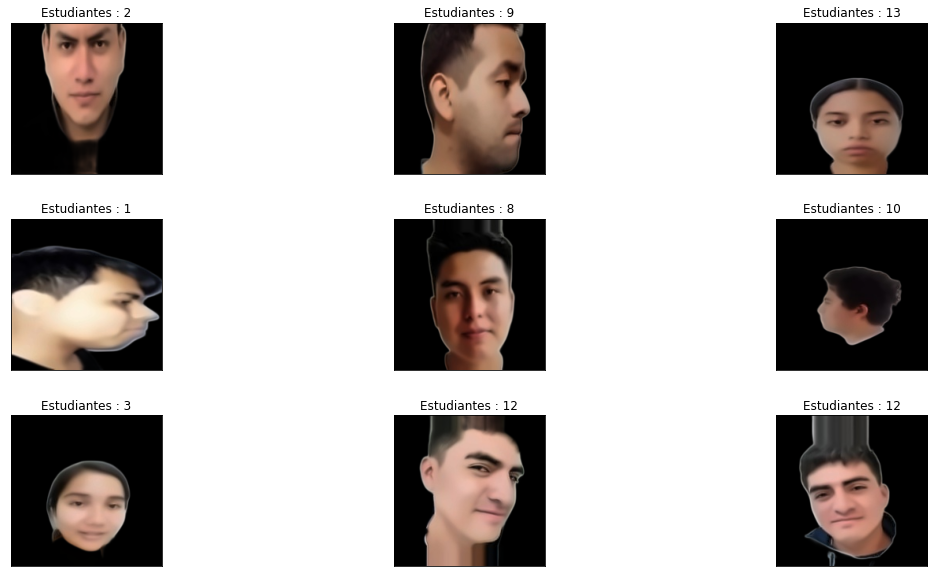

In [234]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Estudiantes : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

# Preparar el dataset para aplicar modelo CNN

In [223]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 2497 2498 2499]

'n' values after shuffling =  [ 629 2345    5 ...  501  348  382]


In [224]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Forma de las imágenes después de Normalizar = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Forma de las imágenes después de Normalizar =  (2500, 192, 192, 3) 
Labels shape after shuffling =  (2500,)


In [225]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (2500, 192, 192, 3)


In [226]:
images = images.astype(np.float32) #Convertimos las imagenes a tipo flotante
labels = labels.astype(np.int32) #Las etiquetas en tipo de int
images = images/255 #Normalizamos
print("Forma de las imágenes después de la normalización = ",images.shape) #Comprabamos que todas tengas las mismas etquetas

Forma de las imágenes después de la normalización =  (2500, 192, 192, 3)


# DIVIDIR EL DATAST

In [228]:
from sklearn.model_selection import train_test_split #permite dividir un dataset en dos bloques,

train_ds, test_ds, train_labels, test_labels =train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("train_ds  = ",train_ds.shape) #Mostramos el valor de entrenar
print("train_labels = ",train_labels.shape) #Mostramos las etiquetas de entramientos
print("\ntest_ds = ",test_ds.shape) #Los test de la imágen
print("test_labels= ",test_labels.shape) #Los test de labels

train_ds  =  (2000, 192, 192, 3)
train_labels =  (2000,)

test_ds =  (500, 192, 192, 3)
test_labels=  (500,)


In [150]:
import tensorflow as tf
train_ds = tf.image.resize(train_ds, (227, 227))
test_ds = tf.image.resize(test_ds, (227, 227))

# Define CNN model

In [151]:
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
#Conv2D = Aplica una convolución 2D sobre una señal de entrada compuesta por varios planos de entrada
#MaxPooling2D = tipo de capa que usa una red convolucional para reconocimiento de imágenes 
#Dense = Las capas Dense son la capas de cálculo de que conectan cada neurona en una capa con todas las salidas de la capa anterior.
#Flatten = La función Flatten agrega argumentos en el orden en que se incluyen en la fórmula.
#Dropout = El dropout se ha utilizado desde su concepción como un método de regularización de los modelos.

#Código que responde a la descripción anterior
#Instanciamos el modelo
model=Sequential()
#Primera capa convolucional
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))
# Primera capa max pool 
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
#Normalizacion batch
model.add(BatchNormalization())
#2 Segunda capa convolucional
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))
#2 Segunda  capa max pool 
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
#Normalizacion batch
model.add(BatchNormalization())
# Tercera capa convolucional
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))
# Cuarta capa convolucional
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))
#Quinta capa convolucional
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))
#Tercers capa max pool 
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
#Normalizacion pro lote
model.add(BatchNormalization())
#Redimensionar el modelo AlexNet
model.add(Flatten())
#Primera capa de densidad
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))
#regularizar neuronas
model.add(Dropout(0.4))
#normalizacion por lote
model.add(BatchNormalization())
#Segunda capa de densidad
model.add(Dense(4096,activation="relu"))
#Regularizar neuronas
model.add(Dropout(0.4))
#normalizacion por lotes
model.add(BatchNormalization())
#Tercera capa de densidad
model.add(Dense(1000,activation="relu"))
#regularizar neuronas
model.add(Dropout(0.4))
#normalizacion por lote
model.add(BatchNormalization())
#capa de salida
model.add(Dense(26,activation="softmax"))
#resumen
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 11, 11, 256)      0         
 g2D)                                                            
                                                     

# Aplicando Early Stopping

In [152]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200) #valores perdidos = val_loss dependiendo 
#de esto se ejecuta aerlyStrogin, patience el tiempo de respueta para que el acurracy suba

In [153]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [154]:
%%time
model.fit(train_ds, train_labels,  epochs=50, validation_data = (test_ds, test_labels),callbacks=[es]) 
#Uso del método fit para los valores de entramiento

Epoch 1/50
63/63 [==============================] - 165s 2s/step - loss: 3.1769 - accuracy: 0.1685 - val_loss: 54.1337 - val_accuracy: 0.0480
Epoch 2/50
63/63 [==============================] - 149s 2s/step - loss: 2.5810 - accuracy: 0.2650 - val_loss: 30.7545 - val_accuracy: 0.0480
Epoch 3/50
63/63 [==============================] - 149s 2s/step - loss: 2.1472 - accuracy: 0.3570 - val_loss: 29.9027 - val_accuracy: 0.0480
Epoch 4/50
63/63 [==============================] - 136s 2s/step - loss: 1.8198 - accuracy: 0.4445 - val_loss: 26.8860 - val_accuracy: 0.0480
Epoch 5/50
63/63 [==============================] - 136s 2s/step - loss: 1.5124 - accuracy: 0.5365 - val_loss: 11.5294 - val_accuracy: 0.0580
Epoch 6/50
63/63 [==============================] - 135s 2s/step - loss: 1.1971 - accuracy: 0.6305 - val_loss: 16.4810 - val_accuracy: 0.0520
Epoch 7/50
63/63 [==============================] - 134s 2s/step - loss: 1.0476 - accuracy: 0.6760 - val_loss: 9.8565 - val_accuracy: 0.0860
Epoch 8

In [155]:
loss, accuracy = model.evaluate(test_ds, test_labels) #Perdida y precisión, en la imágen de test y las etquetas de test
print(loss,accuracy) #Mostramos la perdidad y la precisión

16/16 [==============================] - 8s 476ms/step - loss: 0.4932 - accuracy: 0.8780
0.4932173490524292 0.878000020980835


In [ ]:
# listamos las clases
images_path = r"C:\Users\JHONZ\Desktop\V2-IAPRO\Dataset"
clases_nombres = os.listdir(images_path)
clases_nombres.sort()
print(clases_nombres)

In [182]:
pred = model.predict(test_ds) #Instanciamos la clase model.predict y mandamos por parametro el test
pred.shape #mostramos la prediccion

16/16 [==============================] - 16s 489ms/step


(500, 26)

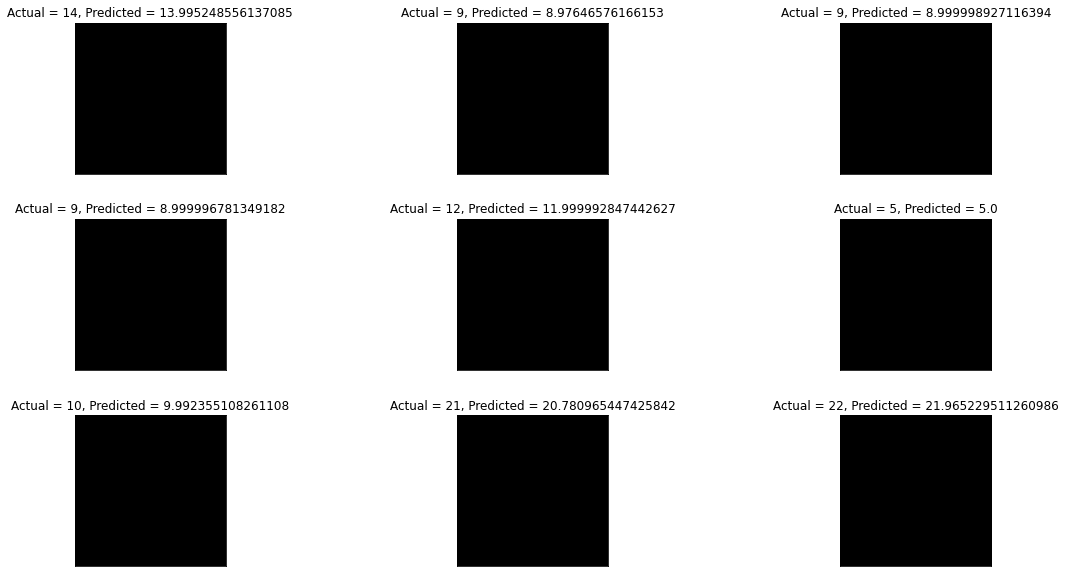

In [239]:
# Definir el tamaño de las figuras
plt.figure(1 , figsize = (19 , 10))
# Definimos un contador
n = 0 
# Bucle para mostrar las imagenes
for i in range(9):
    # Incrementamos el contador
    n += 1 
    # Obtenemos una imagen aleatoria
    r = np.random.randint( 0, test_ds.shape[0], 1)
    # Establecemos la forma de presentar las imagenes
    plt.subplot(3 , 3 , n)
    # Ajustamos la forma de mostrar las imagenes
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    # obtenemos la imagen actual para mostrar
    plt.imshow(test_ds[r[0]])
    # Asignamos las etiquetas
    plt.title('Actual = {}, Predicted = {}'.format(test_labels[r[0]] , test_labels[r[0]]*pred[r[0]][test_labels[r[0]]]) )
    # Establecemos la medida x, y
    plt.xticks([]) , plt.yticks([])

# Mostramos la gráfica
plt.show()

In [237]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("reconocimientoIA.tflite", 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\JHONZ\AppData\Local\Temp\tmpwzwak7wn\assets


INFO:tensorflow:Assets written to: C:\Users\JHONZ\AppData\Local\Temp\tmpwzwak7wn\assets


In [238]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\JHONZ\AppData\Local\Temp\tmpek880zeo\assets


INFO:tensorflow:Assets written to: C:\Users\JHONZ\AppData\Local\Temp\tmpek880zeo\assets
